# Getting started with Perceval

In this notebook, we aim to reproduce the $\mathsf{CNOT}$ Gate to 
evaluate its performance while demonstrating key features of Perceval. We use as basis the implementation from [[1]](#Reference).

In [16]:
import math

import perceval as pcvl

### Ralph CNOT Gate

We start by building the circuit as defined by the paper above - it is a circuit on six modes (labelled from 0 to 5 from top to bottom) consisting of five beam splitters. Modes 0 and 1 contain the control system while modes 2 and 3 encode the target system. Modes 4 and 5 are unoccupied ancillary modes (they are not displayed, but they are required).

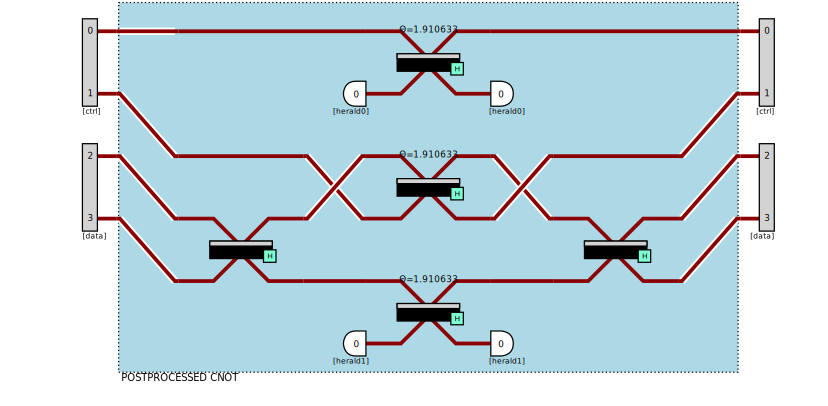

In [17]:
p = pcvl.catalog['postprocessed cnot'].build_processor()

pcvl.pdisplay(p, recursive=True)

Simulations will run on this circuit, using four different input states corresponding to the two-qubit computational basis states. The `Analyzer` is used to compute the gate performance.

In [18]:
states = {
    pcvl.BasicState([1, 0, 1, 0]): "00",
    pcvl.BasicState([1, 0, 0, 1]): "01",
    pcvl.BasicState([0, 1, 1, 0]): "10",
    pcvl.BasicState([0, 1, 0, 1]): "11"
}

ca = pcvl.algorithm.Analyzer(p, states)
ca.compute(expected={"00": "00", "01": "01", "10": "11", "11": "10"})
pcvl.pdisplay(ca)
print(f"performance = {pcvl.simple_float(ca.performance)[1]}, fidelity = {ca.fidelity*100}%")

,00,01,10,11
00,1,0,0,0
01,0,1,0,0
10,0,0,0,1
11,0,0,1,0


performance = 1/9, fidelity = 100.0%


Beyond the actual logic function, what is interesting with this gate us that it produces entangled states that we will be trying to check with CHSH experiment when the source is not perfect.

### Checking for entanglement with CHSH experiment
![https://en.wikipedia.org/wiki/File:Two_channel_bell_test.svg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Two_channel_bell_test.svg/1340px-Two_channel_bell_test.svg.png)
*https://en.wikipedia.org/wiki/File:Two_channel_bell_test.svg*

To reproduce this Bell test protocol, we define a new circuit which uses the $\mathsf{CNOT}$ gate implemented above as a sub-circuit. The parameters $a$ and $b$ describe the measurement bases used by players $A$ and $B$ in the runs of the Bell-test. We define a photon source with a brightness of 40% and a purity of 99% that will be used by the `Processor`.

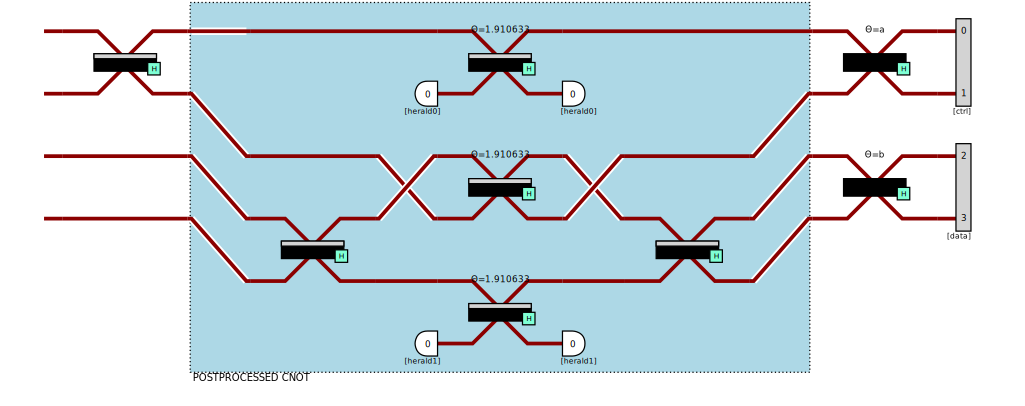

In [19]:
source = pcvl.Source(emission_probability=0.40, multiphoton_component=0.01)

QPU = pcvl.Processor("SLOS", 4, source)
QPU.add(0, pcvl.BS.H())
QPU.add(0, p)

a = pcvl.Parameter("a")
b = pcvl.Parameter("b")

QPU.add(0, pcvl.BS.H(theta=a))
QPU.add(2, pcvl.BS.H(theta=b))

pcvl.pdisplay(QPU, recursive=True)

We start by setting the values of the two parameters to 0, meaning that the beam splitters after the $\mathsf{CNOT}$ effectively act as the identity. 

In [20]:
a.set_value(0)
b.set_value(0)

We now state that our photons will be inputted on ports 0 and 2 (using the 0-index convention, and not counting heralded modes).

In [21]:
QPU.with_input(pcvl.BasicState([1, 0, 1, 0]))

We now detail the different state vectors that are the probabilistic inputs to the circuit. The most frequent input is the empty state, followed by two states with only a single photon on either of the input ports, then by the expected nominal input $|1,0,1,0,0,0\rangle$. Here, the heralded modes are shown because if there were a photon on them, they would also have the imperfect source. They are represented at the end of the state (the two last modes) as they have been added after the declaration of the processor.

In [22]:
pcvl.pdisplay(QPU.source_distribution, precision=1e-4)

state,probability
"|0,0,0,0,0,0>",9/25
"|0,0,{_:0},0,0,0>",0.2395
"|{_:0},0,0,0,0,0>",0.2395
"|{_:0},0,{_:0},0,0,0>",0.1594
"|0,0,{_:0}{_:1},0,0,0>",4.8193e-4
"|{_:0}{_:1},0,0,0,0,0>",4.8193e-4
"|{_:0}{_:1},0,{_:0},0,0,0>",3.2064e-4
"|{_:0},0,{_:0}{_:1},0,0,0>",3.2064e-4
"|{_:0}{_:1},0,{_:0}{_:2},0,0,0>",0


We can then check the output state distribution corresponding to this input distribution. By default, since our input state had 2 photons, only states having at least 2 detected photons are kept. This can be changed using `min_detected_photons_filter`.

In [23]:
output_distribution=QPU.probs()["results"]
pcvl.pdisplay(output_distribution, max_v=10)

state,probability
"|1,0,1,0>",0.495518
"|0,1,0,1>",0.495518
"|0,1,1,0>",0.00747
"|1,0,0,1>",0.001494


Let us run now the experiment with increasing value of g2 in the range $[0, 0.2]$ with a brightness of $0.15$ and check the CHSH inequality.

In [24]:
from tqdm.auto import tqdm
import numpy as np

x = np.arange(0, 20, 0.5)
y = []

for g2 in tqdm(x):
    Es = []
    for va in [0, math.pi/2]:
        a.set_value(va)
        for vb in [math.pi/4, 3*math.pi/4]:
            b.set_value(vb)
            Npp, Npm, Nmp, Nmm = 0, 0, 0, 0
            QPU.source = pcvl.Source(emission_probability=.15, multiphoton_component=g2/100)
            QPU.with_input(pcvl.BasicState([1, 0, 1, 0]))  # with_input has to be called everytime you change a source
            output_distribution = QPU.probs()["results"]
            for output_state, prob in output_distribution.items():
                if (output_state[0] == 1 and output_state[2] == 1):
                    Npp = prob
                if (output_state[0] == 1 and output_state[3] == 1):
                    Npm = prob
                if (output_state[1] == 1 and output_state[2] == 1):
                    Nmp = prob
                if (output_state[1] == 1 and output_state[3] == 1):
                    Nmm = prob
            E = (Npp-Npm-Nmp+Nmm)/(Npp+Npm+Nmp+Nmm)
            Es.append(E)

    S = Es[0]-Es[1]+Es[2]+Es[3]
    print(f"g2 = {g2/100}, S = {S}")
    y.append(S)

  0%|          | 0/40 [00:00<?, ?it/s]

g2 = 0.0, S = 2.8284271247461903
g2 = 0.005, S = 2.792615361258137
g2 = 0.01, S = 2.7572980402457263
g2 = 0.015, S = 2.7224649920120614
g2 = 0.02, S = 2.6881063238088334
g2 = 0.025, S = 2.6542124105426095
g2 = 0.03, S = 2.6207738857392093
g2 = 0.035, S = 2.5877816329598575
g2 = 0.04, S = 2.5552267774696427
g2 = 0.045, S = 2.5231006783080483
g2 = 0.05, S = 2.4913949206290438
g2 = 0.055, S = 2.460101308362304
g2 = 0.06, S = 2.429211857139516
g2 = 0.065, S = 2.3987187875083835
g2 = 0.07, S = 2.368614518400099
g2 = 0.075, S = 2.338891660848145
g2 = 0.08, S = 2.309543011933268
g2 = 0.085, S = 2.2805615489745295
g2 = 0.09, S = 2.251940423920364
g2 = 0.095, S = 2.2236729579593097
g2 = 0.1, S = 2.1957526363162305
g2 = 0.105, S = 2.1681731032549507
g2 = 0.11, S = 2.140928157249369
g2 = 0.115, S = 2.1140117463382824
g2 = 0.12, S = 2.087417963639817
g2 = 0.125, S = 2.0611410430335115
g2 = 0.13, S = 2.0351753549884024
g2 = 0.135, S = 2.0095154025476605
g2 = 0.14, S = 1.9841558174433027
g2 = 0.145,

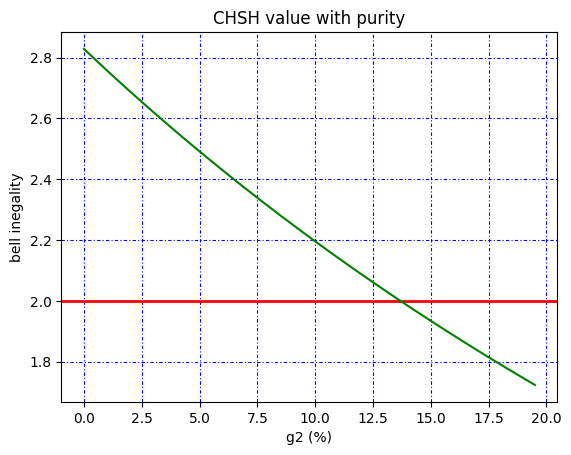

In [25]:
import matplotlib.pyplot as plt
plt.title("CHSH value with purity")
plt.xlabel("g2 (%)")
plt.ylabel("bell inegality")
plt.axhline(y=2, linewidth=2, color="red", label= 'horizontal-line')
plt.plot(x, y, color ="green")
plt.grid(color='b', dashes=(3, 2, 1, 2))
plt.show()

Beyond 13% of g2, we are crossing the value $2$, i.e. not violating anymore the $|CHSH|\le 2$ inegality!

## Reference

> [1] T. C. Ralph, N. K. Langford, T. B. Bell, and A. G. White. Linear optical controlled-NOT gate in the coincidence basis. [Physical Review A](https://link.aps.org/doi/10.1103/PhysRevA.65.062324), 65(6):062324, June 2002. Publisher: American Physical Society.